In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
#import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss

In [2]:
datadir = 'input/'
gatrain = pd.read_csv(os.path.join(datadir,'gender_age_train.csv'),
                      index_col='device_id')
gatest = pd.read_csv(os.path.join(datadir,'gender_age_test.csv'),
                     index_col = 'device_id')
phone = pd.read_csv(os.path.join(datadir,'phone_brand_device_model.csv'))
# Get rid of duplicate device ids in phone 
phone = phone.drop_duplicates('device_id',keep='first').set_index('device_id')
events = pd.read_csv(os.path.join(datadir,'events.csv'),
                     parse_dates=['timestamp'], index_col='event_id')
appevents = pd.read_csv(os.path.join(datadir,'app_events.csv'), 
                        usecols=['event_id','app_id','is_active'],
                        dtype={'is_active':bool})
applabels = pd.read_csv(os.path.join(datadir,'app_labels.csv'))

In [3]:
gatrain['trainrow'] = np.arange(gatrain.shape[0])
gatest['testrow'] = np.arange(gatest.shape[0])

In [4]:
brandencoder = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = brandencoder.transform(phone['phone_brand'])
gatrain['brand'] = phone['brand']
gatest['brand'] = phone['brand']
Xtr_brand = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.brand)))
Xte_brand = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.brand)))
print('Brand features: train shape {}, test shape {}'.format(Xtr_brand.shape, Xte_brand.shape))

Brand features: train shape (74645, 131), test shape (112071, 131)


In [5]:
m = phone.phone_brand.str.cat(phone.device_model)
modelencoder = LabelEncoder().fit(m)
phone['model'] = modelencoder.transform(m)
gatrain['model'] = phone['model']
gatest['model'] = phone['model']
Xtr_model = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.model)))
Xte_model = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.model)))
print('Model features: train shape {}, test shape {}'.format(Xtr_model.shape, Xte_model.shape))

Model features: train shape (74645, 1667), test shape (112071, 1667)


In [33]:
appevents.head()

,event_id,app_id,is_active,app
0,2,5927333115845830913,True,15408
1,2,-5720078949152207372,False,3384
2,2,-1633887856876571208,False,7620
3,2,-653184325010919369,True,8902
4,2,8693964245073640147,True,18686


In [9]:
appencoder = LabelEncoder().fit(appevents.app_id)
appevents['app'] = appencoder.transform(appevents.app_id)
napps = len(appencoder.classes_)

In [16]:
a = list(events[events.device_id==-9222956879900151005].index)

In [21]:
df = appevents[appevents['event_id'].isin(a)]

In [34]:
df.head()

,event_id,app_id,is_active,app
134870,11281,-7937802522076404023,False,1248
134871,11281,5861860846205000600,False,15328
134872,11281,-1633857878693155547,False,7673
134873,11281,-506173428906005275,False,9117
134874,11281,-1200607960388315089,False,8198


In [83]:
appevents[appevents.app==548].head()

,event_id,app_id,is_active,app
1352,112,-8670045756254444686,False,548
1984,138,-8670045756254444686,False,548
4865,313,-8670045756254444686,False,548
5235,337,-8670045756254444686,False,548
6562,408,-8670045756254444686,False,548


In [29]:
df[df.app==548]

,event_id,app_id,is_active,app
134918,11281,-8670045756254444686,False,548
2056191,205471,-8670045756254444686,False,548
2107001,211711,-8670045756254444686,False,548
3434827,341279,-8670045756254444686,False,548
4482565,446042,-8670045756254444686,False,548
4522855,450249,-8670045756254444686,False,548
5534459,554351,-8670045756254444686,False,548
6605064,662820,-8670045756254444686,True,548
7934959,796155,-8670045756254444686,False,548
9246520,926370,-8670045756254444686,False,548


In [6]:
deviceapps = (appevents.merge(events[['device_id']], how='left',left_on='event_id',right_index=True)
                       .groupby(['device_id','app'])['app'].agg(['size'])
                       .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                       .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                       .reset_index())
deviceapps.head()

,device_id,app,size,trainrow,testrow
0,-9222956879900151005,548,18,21594.0,NaN
1,-9222956879900151005,1096,18,21594.0,NaN
2,-9222956879900151005,1248,26,21594.0,NaN
3,-9222956879900151005,1545,12,21594.0,NaN
4,-9222956879900151005,1664,18,21594.0,NaN


In [7]:
d = deviceapps.dropna(subset=['trainrow'])
Xtr_app = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.app)), 
                      shape=(gatrain.shape[0],napps))
d = deviceapps.dropna(subset=['testrow'])
Xte_app = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.app)), 
                      shape=(gatest.shape[0],napps))
print('Apps data: train shape {}, test shape {}'.format(Xtr_app.shape, Xte_app.shape))

Apps data: train shape (74645, 19237), test shape (112071, 19237)


In [8]:
applabels = applabels.loc[applabels.app_id.isin(appevents.app_id.unique())]
applabels['app'] = appencoder.transform(applabels.app_id)
labelencoder = LabelEncoder().fit(applabels.label_id)
applabels['label'] = labelencoder.transform(applabels.label_id)
nlabels = len(labelencoder.classes_)

In [9]:
devicelabels = (deviceapps[['device_id','app']]
                .merge(applabels[['app','label']])
                .groupby(['device_id','label'])['app'].agg(['size'])
                .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                .reset_index())
devicelabels.head()

,device_id,label,size,trainrow,testrow
0,-9222956879900151005,117,1,21594.0,NaN
1,-9222956879900151005,120,1,21594.0,NaN
2,-9222956879900151005,126,1,21594.0,NaN
3,-9222956879900151005,138,2,21594.0,NaN
4,-9222956879900151005,147,2,21594.0,NaN


In [10]:
d = devicelabels.dropna(subset=['trainrow'])
Xtr_label = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.label)), 
                      shape=(gatrain.shape[0],nlabels))
d = devicelabels.dropna(subset=['testrow'])
Xte_label = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.label)), 
                      shape=(gatest.shape[0],nlabels))
print('Labels data: train shape {}, test shape {}'.format(Xtr_label.shape, Xte_label.shape))

Labels data: train shape (74645, 492), test shape (112071, 492)


In [11]:
Xtrain = hstack((Xtr_brand, Xtr_model, Xtr_app, Xtr_label), format='csr')
Xtest =  hstack((Xte_brand, Xte_model, Xte_app, Xte_label), format='csr')
print('All features: train shape {}, test shape {}'.format(Xtrain.shape, Xtest.shape))

All features: train shape (74645, 21527), test shape (112071, 21527)


In [12]:
targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

In [16]:
def score(clf, random_state = 667):
    kf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    for itrain, itest in kf:
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        #print("{:.5f}".format(log_loss(yte, pred[itest,:])), end=' ')
        #return log_loss(yte, pred[itest, :])
    #print('')
    print("{:.5f}".format(log_loss(y, pred)), end=' ')
    return log_loss(y, pred)

[  1.00000000e-05   3.59381366e-05   1.29154967e-04   4.64158883e-04
   1.66810054e-03   5.99484250e-03   2.15443469e-02   7.74263683e-02
   2.78255940e-01   1.00000000e+00]
2.42089 2.41076 2.38880 2.35239 2.31165 2.28323 2.27516 2.29900 2.36632 2.41221 

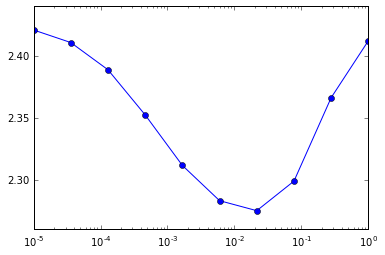

In [14]:
Cs = np.logspace(-5,0,10)
print(Cs)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C, multi_class='multinomial',solver='lbfgs')))
plt.semilogx(Cs, res,'-o');

In [35]:
applabels = applabels.loc[applabels.app_id.isin(appevents.app_id.unique())]

In [37]:
applabels.shape

(78204, 2)

In [38]:
applabels.app_id.unique().shape

(19237,)

In [47]:
applabels.label_id.unique().shape

(492,)

In [48]:
applabels.head()

,app_id,label_id,app,label
0,7324884708820027918,251,17355,207
1,-4494216993218550286,251,4618,207
2,6058196446775239644,406,15548,247
3,6058196446775239644,407,15548,248
4,8694625920731541625,406,18689,247


In [41]:
applabels['app'] = appencoder.transform(applabels.app_id)

In [43]:
labelencoder = LabelEncoder().fit(applabels.label_id)

In [44]:
applabels['label'] = labelencoder.transform(applabels.label_id)
nlabels = len(labelencoder.classes_)

In [50]:
appencoder = LabelEncoder().fit(appevents.app_id)
appevents['app'] = appencoder.transform(appevents.app_id)
napps = len(appencoder.classes_)
deviceapps = (appevents.merge(events[['device_id']], how='left',left_on='event_id',right_index=True)
                       .groupby(['device_id','app'])['app'].agg(['size'])
                       .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                       .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                       .reset_index())
deviceapps.head()

,device_id,app,size,trainrow,testrow
0,-9222956879900151005,548,18,21594.0,NaN
1,-9222956879900151005,1096,18,21594.0,NaN
2,-9222956879900151005,1248,26,21594.0,NaN
3,-9222956879900151005,1545,12,21594.0,NaN
4,-9222956879900151005,1664,18,21594.0,NaN


In [54]:
deviceapps[deviceapps.device_id==-9222956879900151005].size.sum()

360

In [51]:
devicelabels = (deviceapps[['device_id','app']]
                .merge(applabels[['app','label']])
                .groupby(['device_id','label'])['app'].agg(['size'])
                .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                .reset_index())
devicelabels.head()

,device_id,label,size,trainrow,testrow
0,-9222956879900151005,117,1,21594.0,NaN
1,-9222956879900151005,120,1,21594.0,NaN
2,-9222956879900151005,126,1,21594.0,NaN
3,-9222956879900151005,138,2,21594.0,NaN
4,-9222956879900151005,147,2,21594.0,NaN


In [76]:
devicelabels[devicelabels.device_id==-9222956879900151005]

,device_id,label,size,trainrow,testrow
0,-9222956879900151005,117,1,21594.0,NaN
1,-9222956879900151005,120,1,21594.0,NaN
2,-9222956879900151005,126,1,21594.0,NaN
3,-9222956879900151005,138,2,21594.0,NaN
4,-9222956879900151005,147,2,21594.0,NaN
5,-9222956879900151005,170,1,21594.0,NaN
6,-9222956879900151005,181,1,21594.0,NaN
7,-9222956879900151005,190,1,21594.0,NaN
8,-9222956879900151005,207,8,21594.0,NaN
9,-9222956879900151005,208,11,21594.0,NaN


In [55]:
devicelabels[devicelabels.device_id==-9222956879900151005].size.sum()

280

In [56]:
label_cat = pd.read_csv(os.path.join(datadir,'label_categories.csv'))

In [70]:
label_cat.head()

,label_id,category
0,1,NaN
1,2,game-game type
2,3,game-Game themes
3,4,game-Art Style
4,5,game-Leisure time


In [65]:
applabels.head()

,app_id,label_id,app,label
0,7324884708820027918,251,17355,207
1,-4494216993218550286,251,4618,207
2,6058196446775239644,406,15548,247
3,6058196446775239644,407,15548,248
4,8694625920731541625,406,18689,247


In [71]:
applabels.label_id.unique().shape

(492,)

In [72]:
applabels = applabels.merge(label_cat,how='inner',on='label_id')

In [73]:
applabels.head()

,app_id,label_id,app,label,category
0,7324884708820027918,251,17355,207,Finance
1,-4494216993218550286,251,4618,207,Finance
2,8756705988821000489,251,18741,207,Finance
3,1061207043315821111,251,10841,207,Finance
4,-1491198667294647703,251,7857,207,Finance


In [75]:
applabels.category.unique()

array(['Finance', 'unknown', 'DS_P2P net loan', 'Securities',
       'Lottery ticket', 'IMF', 'Precious Metals', 'pursue',
       'Science and Technology', 'Customization', 'service',
       'Smart Shopping', 'Personal Effectiveness', 'free', 'vitality',
       'Trendy / cool', 'Relatives', 'comfortable', 'Simple',
       'Debit and credit', 'Crowdfunding financing', 'Custom label',
       'Ping', 'safety Insurance', 'Peace - Search', 'mobile bank',
       'Direct Bank', 'futures', 'Property Industry 1.0', 'Industry tag',
       'Pay', 'Wealth Management', '1 free', 'Cozy 1', 'Services 1',
       'Pursuit 1', 'Trendy / cool 1', 'Customized 1', 'Passion 1',
       'Noble 1', 'Personal Effectiveness 1', 'Total Cost 1',
       'Smart Shopping 1', 'Science and Technology 1', 'Relatives 1',
       'Irritation / Fun 1', '1 vitality', 'Quality 1', '1 reputation',
       'Nature 1', 'Simple 1', 'Classical 1', 'Property Industry 2.0',
       'Occupational identity', 'College Students',
       '